E:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TEST_MODE is ON – running in test mode (reduced data, fewer trials).


[I 2025-06-29 11:09:04,642] A new study created in memory with name: no-name-2eb25274-041b-4135-ab23-81050a95bf24


[I 2025-06-29 11:09:10,100] Trial 0 finished with value: 96228.57202474584 and parameters: {'iterations': 419, 'depth': 5, 'learning_rate': 0.10155184120646811, 'l2_leaf_reg': 0.2194630226679594, 'bagging_temperature': 0.8576457080975471, 'random_strength': 0.3963005047786231}. Best is trial 0 with value: 96228.57202474584.


[I 2025-06-29 11:09:39,801] Trial 1 finished with value: 99411.07882305887 and parameters: {'iterations': 834, 'depth': 9, 'learning_rate': 0.01374301985986667, 'l2_leaf_reg': 0.00799238957753459, 'bagging_temperature': 0.2850039997858881, 'random_strength': 0.8332896517623534}. Best is trial 0 with value: 96228.57202474584.


[I 2025-06-29 11:09:45,836] Trial 2 finished with value: 93724.22997349108 and parameters: {'iterations': 406, 'depth': 6, 'learning_rate': 0.24613316611366923, 'l2_leaf_reg': 2.3571351348036376, 'bagging_temperature': 0.9485544901119751, 'random_strength': 0.06644582299245694}. Best is trial 2 with value: 93724.22997349108.


[I 2025-06-29 11:09:47,182] A new study created in memory with name: no-name-41bff4f9-5988-4068-9d05-96e235a9f11f


[I 2025-06-29 11:09:52,091] Trial 0 finished with value: 96188.50587626993 and parameters: {'iterations': 349, 'depth': 6, 'learning_rate': 0.2113311061425382, 'l2_leaf_reg': 0.006753134306293925, 'bagging_temperature': 0.30916215873838604, 'random_strength': 0.705623302802596}. Best is trial 0 with value: 96188.50587626993.


[I 2025-06-29 11:10:53,945] Trial 1 finished with value: 96523.3395586049 and parameters: {'iterations': 924, 'depth': 10, 'learning_rate': 0.14748233029410035, 'l2_leaf_reg': 0.013627034307692541, 'bagging_temperature': 0.879549202192268, 'random_strength': 0.9138099441503131}. Best is trial 0 with value: 96188.50587626993.


[I 2025-06-29 11:11:00,706] Trial 2 finished with value: 96324.86230006261 and parameters: {'iterations': 580, 'depth': 5, 'learning_rate': 0.25920778679897294, 'l2_leaf_reg': 0.0011238170825531104, 'bagging_temperature': 0.17808471657089775, 'random_strength': 0.2834107500811315}. Best is trial 0 with value: 96188.50587626993.


Evaluation – CatBoost + Optuna CV (All Features)
  MAE:  48,260.80 €
  RMSE: 67,984.33 €
  R²:   0.8941
----------------------------------------
Evaluation – CatBoost + Optuna CV (Top RF Features)
  MAE:  51,478.16 €
  RMSE: 72,016.86 €
  R²:   0.8812
----------------------------------------
[✓] Model evaluation for 'CatBoost + Optuna CV (All Features)' logged.
[✓] Model evaluation for 'CatBoost + Optuna CV (Top RF Features)' logged.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,82,2025-06-29 11:06:44,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,Linear Regression (All Features),202506291106,76 898.76 €,109 935.46 €,0.723000,Linear,6,1.430000,
1,83,2025-06-29 11:07:10,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,Random Forest (All Features),202506291106,68 324.02 €,101 428.25 €,0.764200,Tree,4,1.480000,
2,84,2025-06-29 11:07:19,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,Random Forest (Top 10 Features),202506291106,71 734.61 €,106 140.03 €,0.741800,Tree,5,1.480000,
3,85,2025-06-29 11:08:51,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,XGBoost with Optuna (All Features) [TEST],202506291106,16 937.08 €,23 554.49 €,0.987300,Boosting,2,1.390000,
4,86,2025-06-29 11:08:51,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291106,1 621.04 €,6 090.36 €,0.999200,Boosting,1,3.760000,✓
5,87,2025-06-29 11:11:01,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,CatBoost with Optuna (All Features),202506291106,48 260.80 €,67 984.33 €,0.894100,Boosting,3,1.410000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,82,2025-06-29 11:06:44,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,Linear Regression (All Features),202506291106,76 898.76 €,109 935.46 €,0.723000,Linear,7,1.430000,
1,83,2025-06-29 11:07:10,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,Random Forest (All Features),202506291106,68 324.02 €,101 428.25 €,0.764200,Tree,5,1.480000,
2,84,2025-06-29 11:07:19,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,Random Forest (Top 10 Features),202506291106,71 734.61 €,106 140.03 €,0.741800,Tree,6,1.480000,
3,85,2025-06-29 11:08:51,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,XGBoost with Optuna (All Features) [TEST],202506291106,16 937.08 €,23 554.49 €,0.987300,Boosting,2,1.390000,
4,86,2025-06-29 11:08:51,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291106,1 621.04 €,6 090.36 €,0.999200,Boosting,1,3.760000,✓
5,87,2025-06-29 11:11:01,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,CatBoost with Optuna (All Features),202506291106,48 260.80 €,67 984.33 €,0.894100,Boosting,3,1.410000,
6,88,2025-06-29 11:11:01,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1106.csv,CatBoost with Optuna (Top RF Features),202506291106,51 478.16 €,72 016.86 €,0.881200,Boosting,4,1.400000,



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) [TEST] ✓
Diagnostics (All Features):


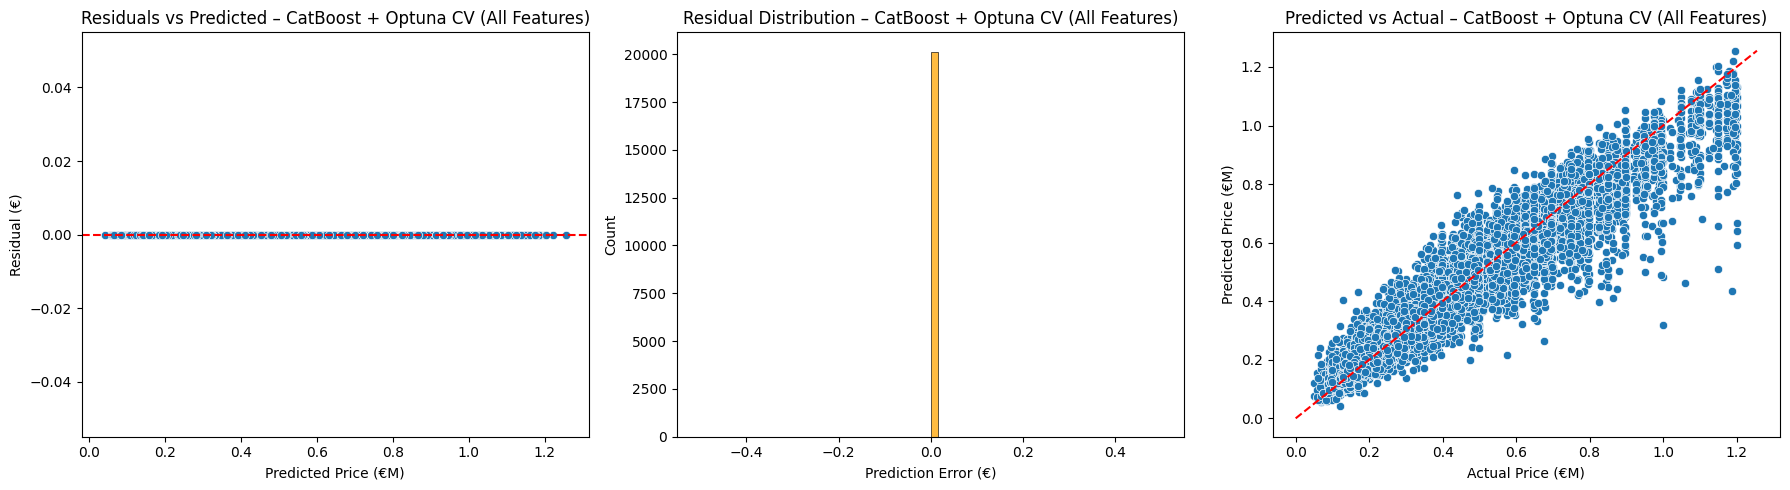

Diagnostics (Top RF Features):


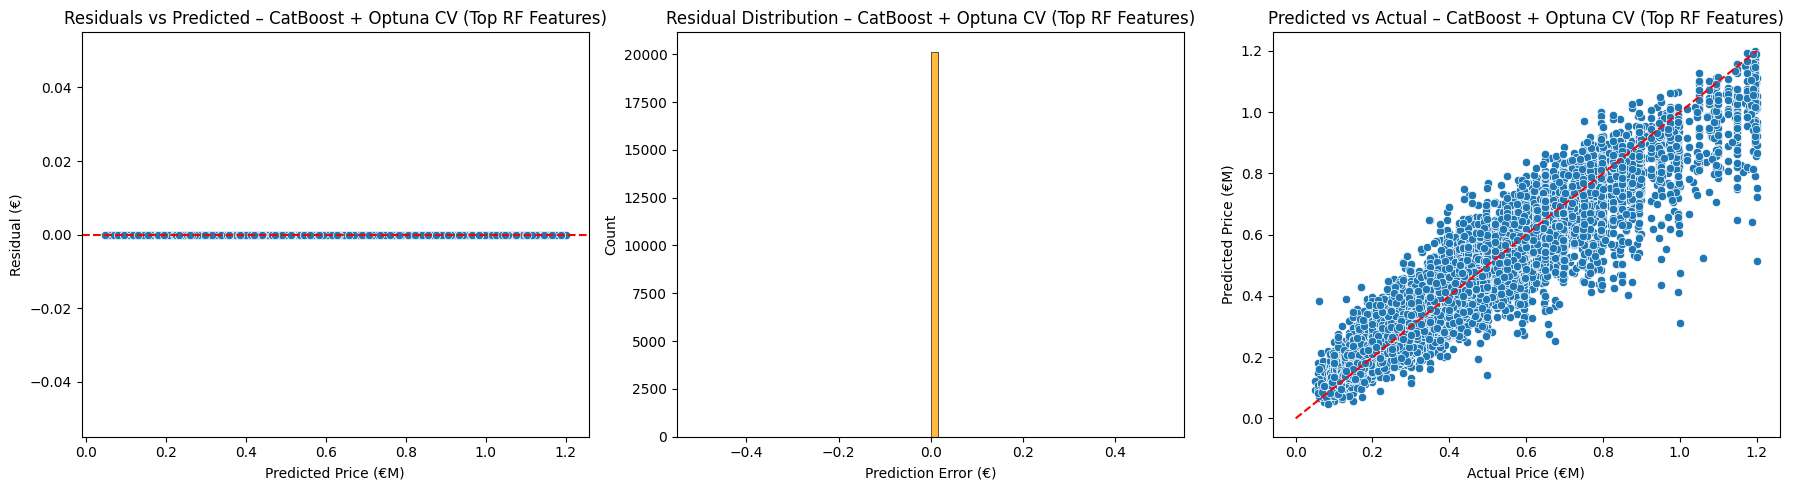

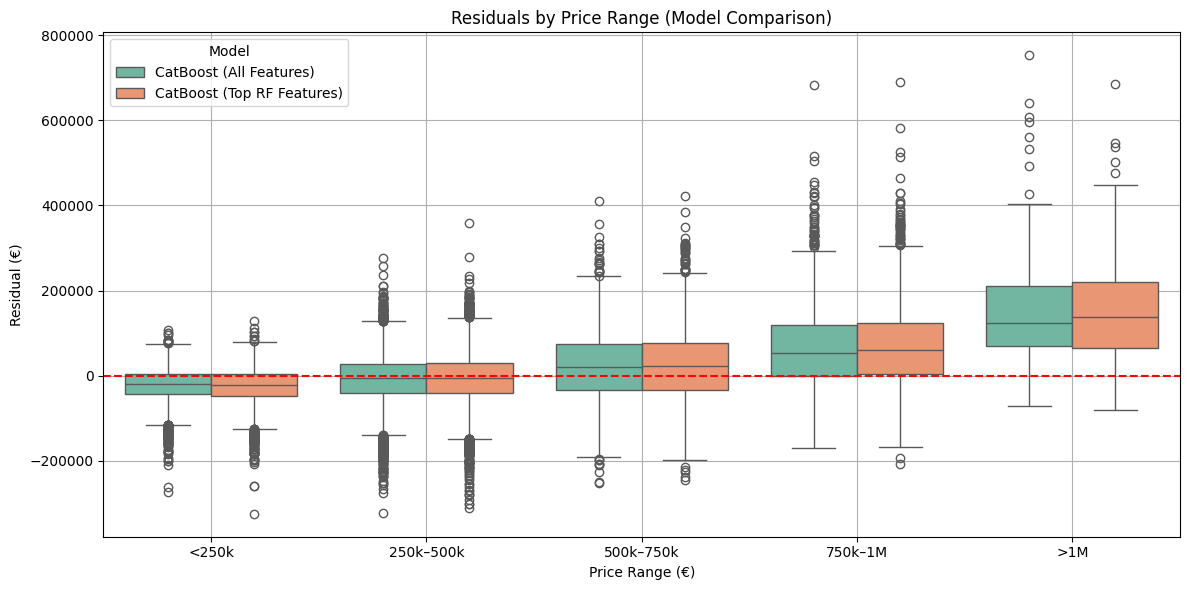

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [1]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


if TEST_MODE:
    print("TEST_MODE is ON – running in test mode (reduced data, fewer trials).")
else:
    print("TEST_MODE is OFF – full training is active.")


# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# Step 2: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_reduced, y)
top_features = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).nlargest(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna objective for CatBoost
def tune_catboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
        }

        model = CatBoostRegressor(
            **params,
            verbose=0,
            loss_function="RMSE",
            random_state=42
        )

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in cv.split(X_data):
            X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
            y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            scores.append(root_mean_squared_error(y_val, preds))
        return np.mean(scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

# All Features
study_all = tune_catboost_with_optuna(X_reduced, y, n_trials)
model_all = CatBoostRegressor(**study_all.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

# Top RF Features
study_top = tune_catboost_with_optuna(X_top, y, n_trials)
model_top = CatBoostRegressor(**study_top.best_params, verbose=0, loss_function="RMSE", random_state=42)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluation
evaluator_all = ModelEvaluator("CatBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("CatBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
tracker = ExperimentTracker()
df_metrics_all = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (All Features)",
    experiment="CatBoost with Optuna (All Features)",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model="CatBoost + Optuna CV (Top RF Features)",
    experiment="CatBoost with Optuna (Top RF Features)",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Summary & Diagnostics
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

print("Diagnostics (All Features):")
ModelVisualizer(model_all, X_reduced, y, "CatBoost + Optuna CV (All Features)").plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
ModelVisualizer(model_top, X_top, y, "CatBoost + Optuna CV (Top RF Features)").plot_all_diagnostics()

# Step 9: Residuals & SHAP Comparison
ModelEvaluator.plot_price_range_residuals_side_by_side(
    y, y_pred_all, y_pred_top,
    model_names=("CatBoost (All Features)", "CatBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""

In [2]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import joblib
from datetime import datetime
from utils.constants import TEST_MODE, MODELS_DIR

# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Add suffix if in TEST mode
suffix = "_TEST" if TEST_MODE else ""

# Define subdirectory for .pkl files
PKL_DIR = os.path.join(MODELS_DIR, "pkl")
if os.path.isfile(PKL_DIR):
    os.remove(PKL_DIR)  # Remove conflicting file if it exists
os.makedirs(PKL_DIR, exist_ok=True)

# Build filenames
filename_all = f"catboost_optuna_all_{timestamp}{suffix}.pkl"
filename_top = f"catboost_optuna_top30_{timestamp}{suffix}.pkl"

# Save models
joblib.dump(model_all, os.path.join(PKL_DIR, filename_all))
joblib.dump(model_top, os.path.join(PKL_DIR, filename_top))

print(f"[✔] CatBoost models saved to '{PKL_DIR}' as:\n - {filename_all}\n - {filename_top}")


[✔] CatBoost models saved to 'E:\_SoftEng\_BeCode\real-estate-price-predictor\models\pkl' as:
 - catboost_optuna_all_20250629_1111_TEST.pkl
 - catboost_optuna_top30_20250629_1111_TEST.pkl
